# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [100]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
from sklearn.preprocessing import LabelEncoder
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import pandas as pd

from uszipcode import SearchEngine

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "wids_datathon"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Import the Data

In [37]:
def load_medical_data(medical_path=""):
    csv_path = os.path.join(medical_path, "training.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

Let's see the shape of the data and the name of the columns 

In [136]:
medical = load_medical_data()
medical.shape

(12906, 83)

In [47]:
medical.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

In [48]:
medical = load_medical_data()
medical.head()

patient_id patient_race  payer_type patient_state  patient_zip3  \
0      475714          NaN    MEDICAID            CA           924   
1      349367        White  COMMERCIAL            CA           928   
2      138632        White  COMMERCIAL            TX           760   
3      617843        White  COMMERCIAL            CA           926   
4      817482          NaN  COMMERCIAL            ID           836   

   patient_age patient_gender    bmi breast_cancer_diagnosis_code  \
0           84              F    NaN                       C50919   
1           62              F  28.49                       C50411   
2           43              F  38.09                       C50112   
3           45              F    NaN                       C50212   
4           55              F    NaN                         1749   

                        breast_cancer_diagnosis_desc  ...   disabled  \
0  Malignant neoplasm of unsp site of unspecified...  ...  12.871429   
1  Malig neoplm of upper-outer quadrant of right ...  ...   8.957576   
2  Malignant neoplasm of central portion of left ...  ...  11.253333   
3  Malig neoplasm of upper-inner quadrant of left...  ...   8.845238   
4  Malignant neoplasm of breast (female), unspeci...  ...  15.276000   

     poverty limited_english commute_time health_uninsured    veteran  \
0  22.542857       10.100000    27.814286        11.200000   3.500000   
1  10.109091        8.057576    30.606061         7.018182   4.103030   
2   9.663333        3.356667    31.394915        15.066667   7.446667   
3   8.688095        5.280952    27.561905         4.404762   4.809524   
4  11.224000        1.946000    26.170213        12.088000  13.106000   

       Ozone      PM25        N02  DiagPeriodL90D  
0  52.237210  8.650555  18.606528               1  
1  42.301121  8.487175  20.113179               1  
2  40.108207  7.642753  14.839351               1  
3  42.070075  7.229393  15.894123               0  
4  41.356058  4.110749  11.722197               0  

[5 rows x 83 columns]

In [49]:
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

There are a lot of missing values... Few features are available for all entries (12906 examples non-null).

In [50]:
medical.isna().sum() 

patient_id           0
patient_race      6385
payer_type        1803
patient_state       51
patient_zip3         0
                  ... 
veteran              1
Ozone               29
PM25                29
N02                 29
DiagPeriodL90D       0
Length: 83, dtype: int64

# Discover and Visualize the Data to Gain Insights

Because the column patient_state has all the values Female we should drop the column, it's irrelevant. 

In [51]:
medical["patient_gender"].value_counts()

patient_gender
F    12906
Name: count, dtype: int64

Let's watch the patients's state 

In [52]:
medical["patient_state"].value_counts()

patient_state
CA    2438
TX    1155
NY    1041
MI     858
IL     782
OH     754
FL     609
GA     551
PA     483
MN     377
CO     371
VA     365
IN     317
KY     259
AZ     229
WI     212
WA     200
NC     186
MO     160
NM     141
LA     139
TN     112
SC     110
ID      93
OK      93
OR      89
IA      86
MS      76
MD      71
AR      63
NV      62
KS      50
AL      50
MT      45
NE      40
UT      36
DE      33
WV      27
HI      21
NJ      21
DC      20
SD       8
ND       6
AK       6
WY       4
CT       2
PR       1
RI       1
NH       1
MA       1
Name: count, dtype: int64

# Visualising the correlations

I want to look for the correlation between the features, but first we will transform them in number values 

In [61]:
medical2 = load_medical_data()

numeric_cols = medical2.select_dtypes(include=['int', 'float']).columns
categorical_cols = medical2.select_dtypes(include=['object', 'string']).columns

label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    medical2[col] = label_encoders[col].fit_transform(medical2[col])

In [58]:
correlation_matrix = medical2.corr()

sorted_correlation_matrix = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()

correlations_with_DiagPeriodL90D = correlation_matrix['DiagPeriodL90D'].sort_values(ascending=False)

sorted_correlations_with_DiagPeriodL90D = correlations_with_DiagPeriodL90D.drop_duplicates()
sorted_correlations_with_DiagPeriodL90D

DiagPeriodL90D                      1.000000
breast_cancer_diagnosis_code        0.498536
breast_cancer_diagnosis_desc        0.076746
payer_type                          0.071495
patient_age                         0.055634
                                      ...   
widowed                            -0.031544
patient_state                      -0.034108
education_less_highschool          -0.035954
metastatic_cancer_diagnosis_code   -0.090909
patient_gender                           NaN
Name: DiagPeriodL90D, Length: 83, dtype: float64

Saving figure Correlation Heatmap


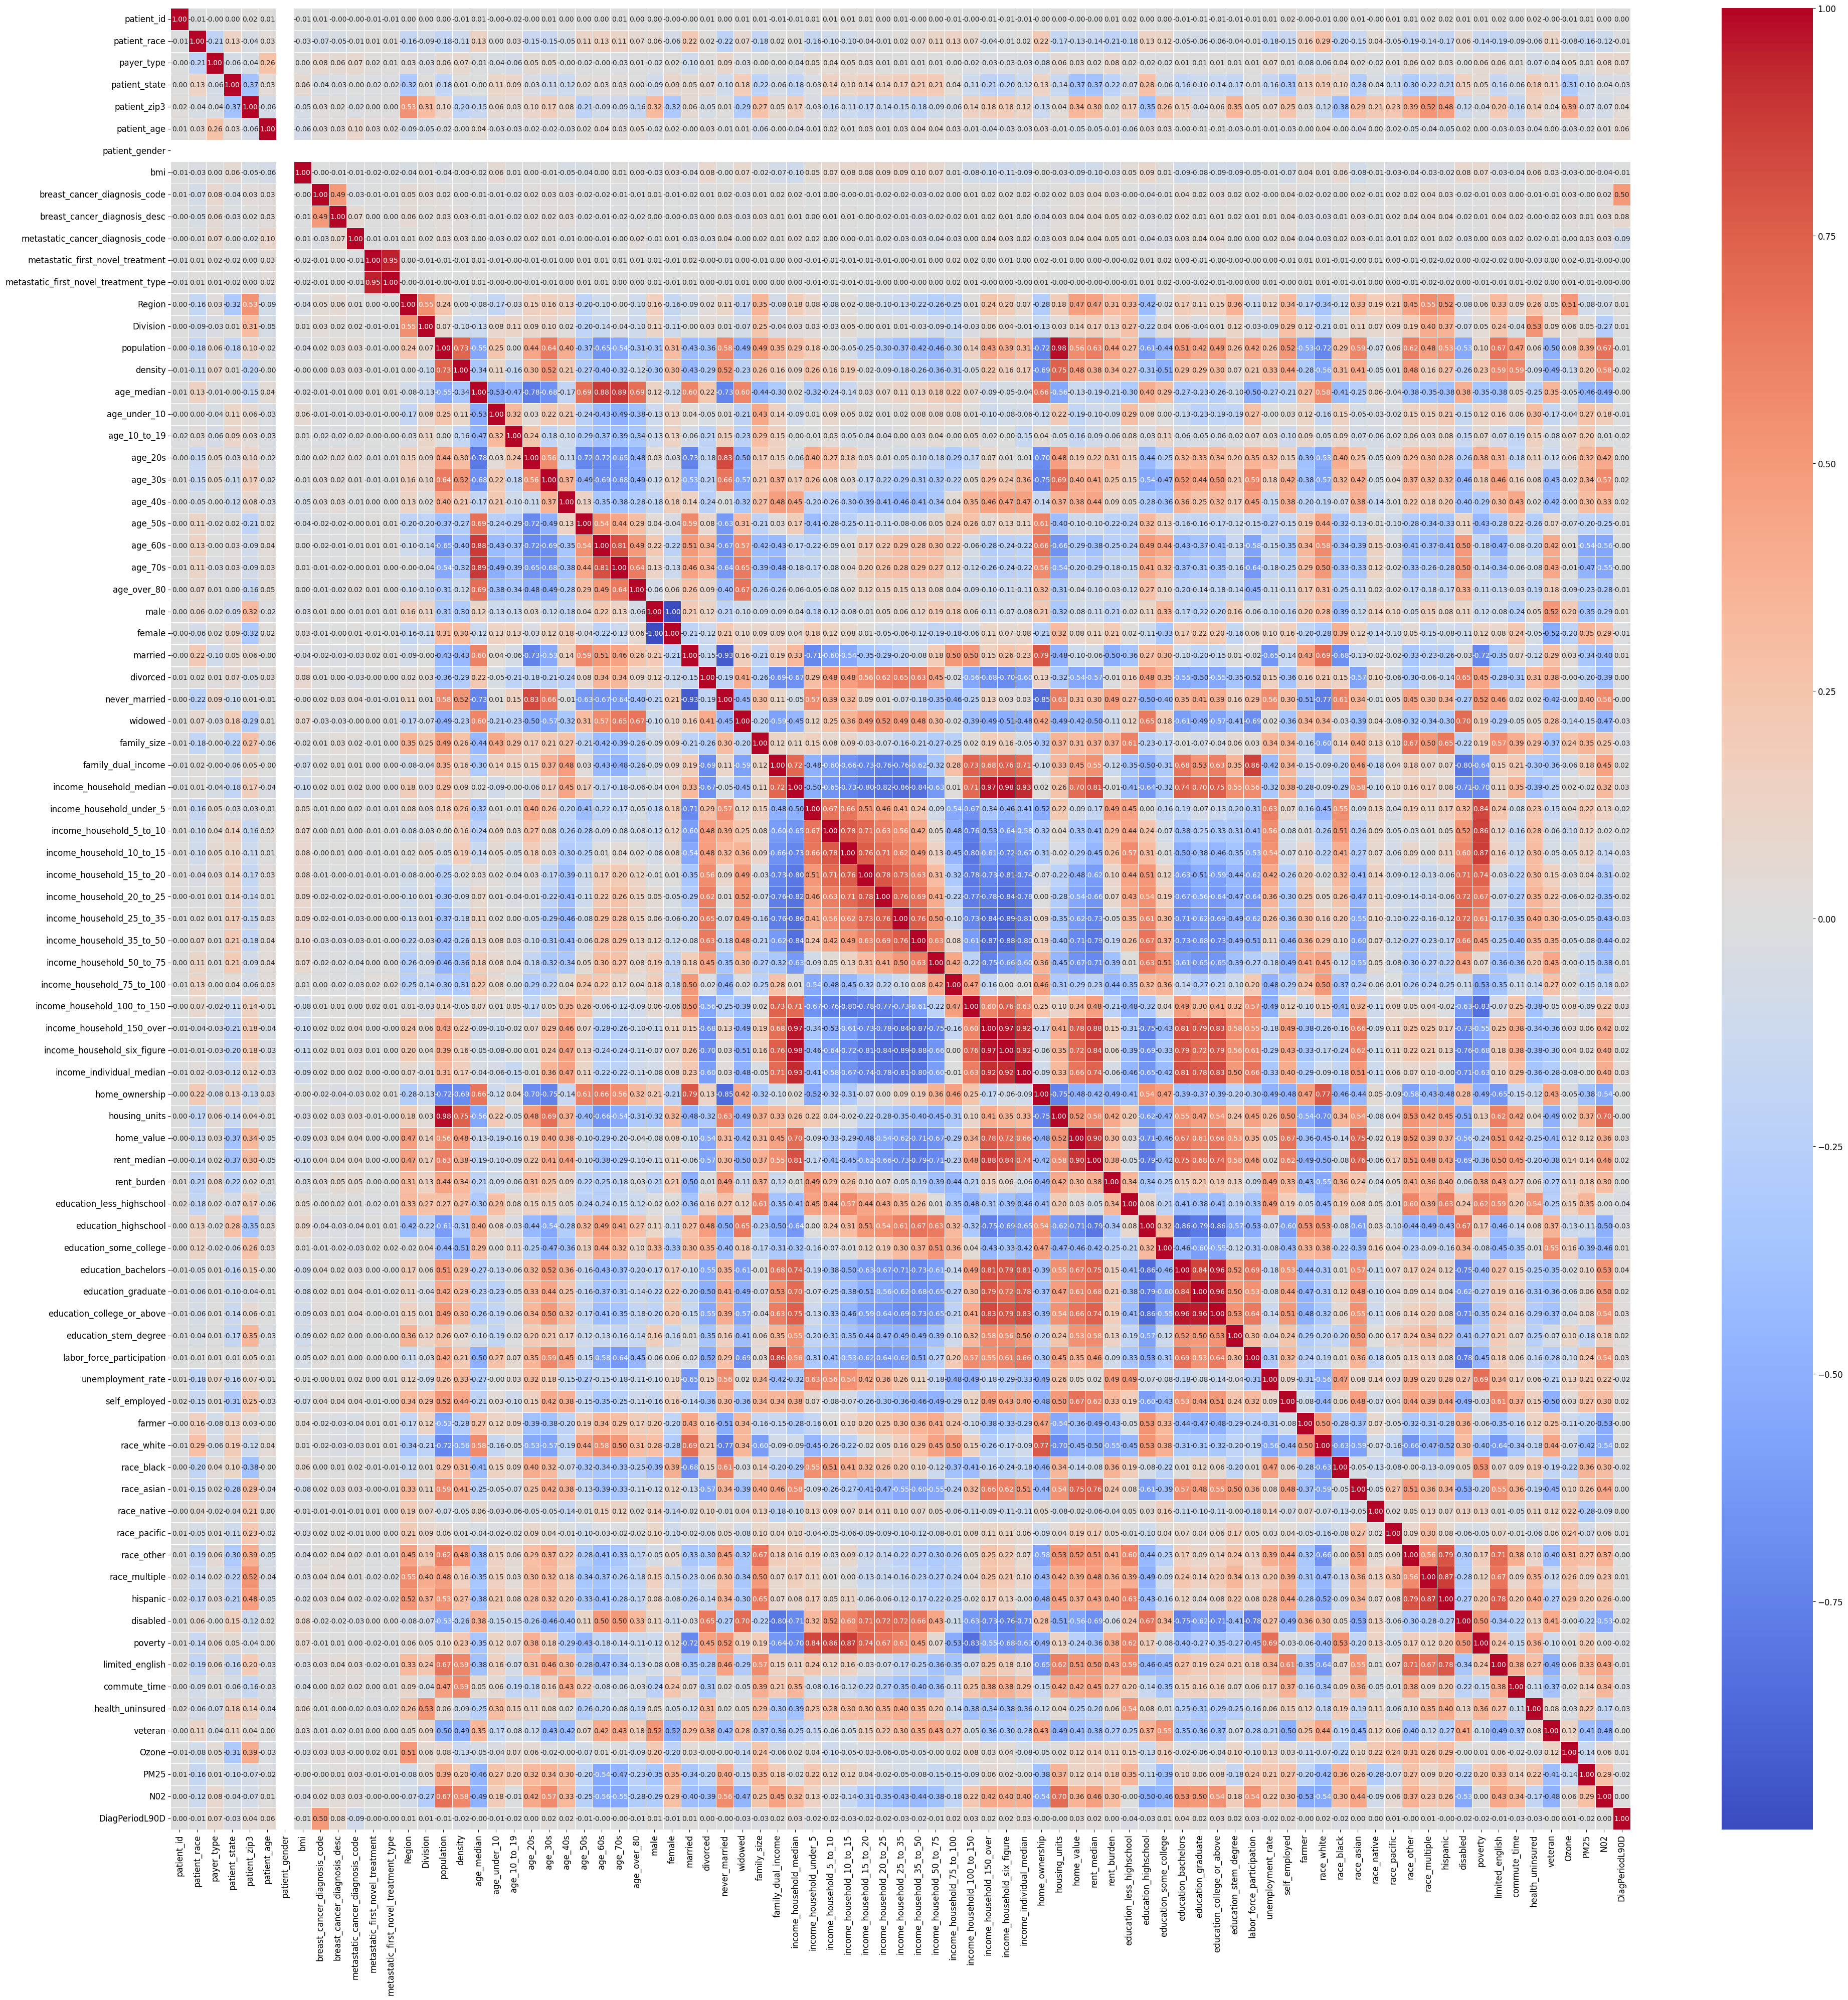

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
save_fig("Correlation Heatmap")
plt.show()

Saving figure Pairplot


<Figure size 10000x10000 with 0 Axes>

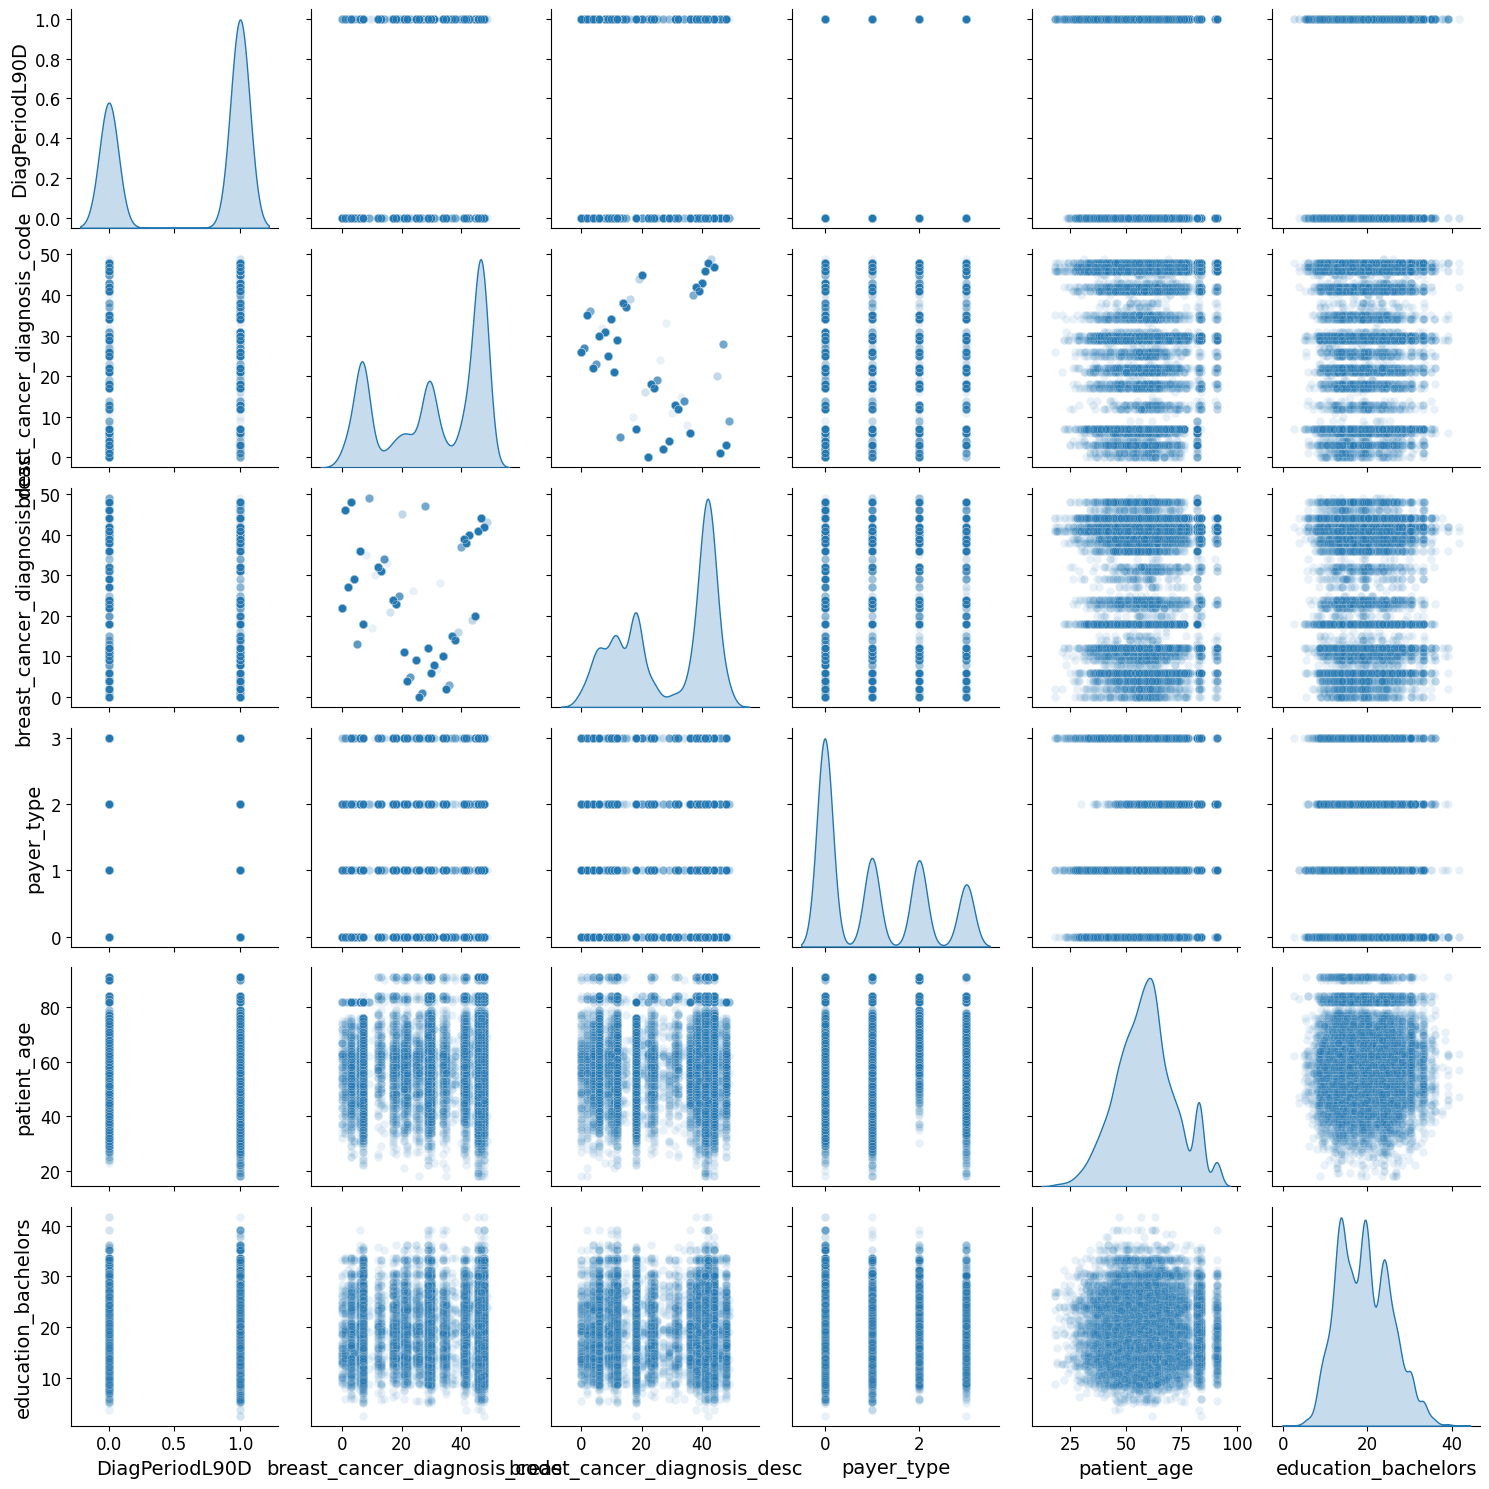

In [79]:
plt.figure(figsize=(100,100))
pairplot = sns.pairplot(medical2[["DiagPeriodL90D", "breast_cancer_diagnosis_code", "breast_cancer_diagnosis_desc", "payer_type", "patient_age", "education_bachelors"]], diag_kind='kde', plot_kws={'alpha':0.1})
save_fig("Pairplot")
pairplot

In [153]:
medical.fillna({col: "patient_race"}, inplace=True)
medical.groupby("patient_race")["bmi"].mean()

patient_race
Asian       26.048571
Black       30.707333
Hispanic    30.082155
Other       28.477040
White       28.811565
nan         28.881830
Name: bmi, dtype: float64

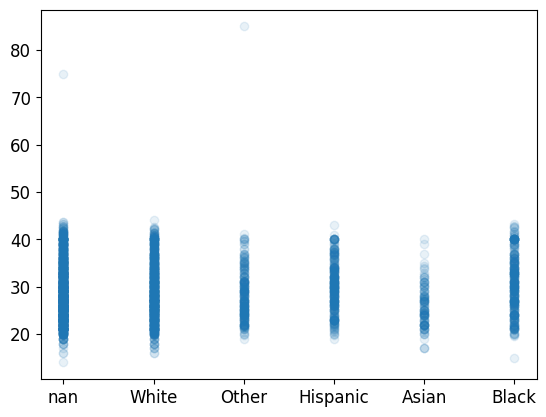

In [154]:
medical["patient_race"] = medical["patient_race"].astype(str)
plt.scatter(medical["patient_race"].tolist(), medical["bmi"].tolist(), alpha=0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'DiagPeriodL90D')

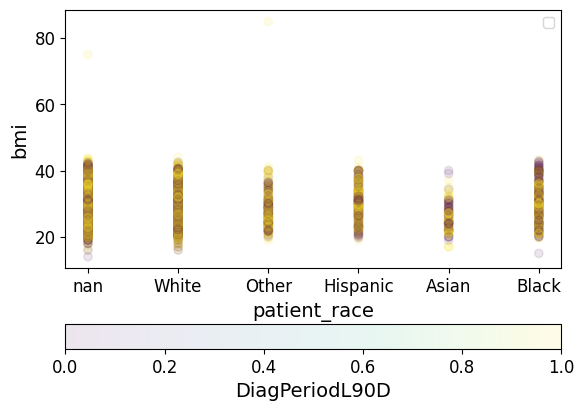

In [168]:
plt.scatter(medical["patient_race"].tolist(), medical["bmi"].tolist(), c=medical['DiagPeriodL90D'].tolist(), alpha=0.1)
plt.xlabel('patient_race')
plt.ylabel('bmi')
plt.legend()
cbar = plt.colorbar(orientation='horizontal')
cbar.ax.set_xlabel('DiagPeriodL90D')

In [167]:
mapping = dict(zip(medical['patient_race'], medical2['patient_race']))
unique_mapping = {value: key for key, value in mapping.items()}
print(unique_mapping)

{5: 'nan', 4: 'White', 3: 'Other', 2: 'Hispanic', 0: 'Asian', 1: 'Black'}


 # Data Cleaning 

As I said before, as patient_gender has just a value and it's irrelevant.  

In [80]:
medical.drop(columns= ["patient_gender"])
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 84 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

Let's fill in the patient states with the information obtained from the zip3 code. We will also check for any inconsistencies between the state and zip3. 

In [112]:
sr = SearchEngine()
z = sr.by_prefix(760)
print(z[0].state)
print(z[0].state)

TX


In [137]:
sr = SearchEngine()
repaired_states = 0
state_inconsistencies = 0
incorrect_zip3s = 0
for ind in medical.index:
    # try:
    if medical.isnull().loc[ind,"patient_state"]:
        medical.loc[ind, "patient_state"] = sr.by_prefix(medical["patient_zip3"][ind])[0].state
        repaired_states += 1
    elif len(sr.by_prefix(medical["patient_zip3"][ind])) == 0:
        incorrect_zip3s += 1
    elif medical["patient_state"][ind] != sr.by_prefix(medical["patient_zip3"][ind])[0].state:
        medical.loc[ind, "patient_state"] = sr.by_prefix(medical["patient_zip3"][ind])[0].state
        state_inconsistencies += 1
    # except Exception as err:
    #     print(f"Unexpected {err=}, {type(err)=}")
    #     print(f"Patient zip3:{medi}")
print(f"Repaired States: {repaired_states}")
print(f"State inconsistencies: {state_inconsistencies}")
print(f"Incorrect zip3s (for inconsistency check): {incorrect_zip3s}")
print(medical["patient_state"])

Repaired States: 51
State inconsistencies: 166
Missing states: 1
0        CA
1        CA
2        TX
3        CA
4        ID
         ..
12901    OH
12902    CA
12903    CA
12904    NY
12905    FL
Name: patient_state, Length: 12906, dtype: object


If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [12]:
medical["median_income"].hist()

KeyError: 'median_income'

In [0]:
medical["income_cat"] = pd.cut(medical["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [0]:
medical["income_cat"].value_counts()

In [0]:
medical["income_cat"].hist()

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(medical, medical["income_cat"]):
    strat_train_set = medical.loc[train_index]
    strat_test_set = medical.loc[test_index]

In [0]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

In [0]:
medical["income_cat"].value_counts() / len(medical)

In [0]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(medical),
    "Stratified": income_cat_proportions(strat_test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [0]:
compare_props

In [0]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [ ]:
medical = strat_train_set.copy()

## Visualizing Geographical Data

In [ ]:
medical.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

In [ ]:
medical.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.

In [ ]:
medical.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=medical["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("medical_prices_scatterplot")

## Looking for Correlations

In [ ]:
corr_matrix = medical.corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "medical_median_age"]
scatter_matrix(medical[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [ ]:
medical.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

## Experimenting with Attribute Combinations

In [ ]:
medical["rooms_per_household"] = medical["total_rooms"]/medical["households"]
medical["bedrooms_per_room"] = medical["total_bedrooms"]/medical["total_rooms"]
medical["population_per_household"]=medical["population"]/medical["households"]

In [ ]:
corr_matrix = medical.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
medical.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [ ]:
medical.describe()

# Prepare the Data for Machine Learning Algorithms

In [ ]:
medical = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
medical_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [34]:
zcdb = ZipCodeDatabase()
for ind in medical.index:
    if medical.isnull().loc(ind,"patient_state2"):
        medical["patient_state2"][ind] = medical["patient_zip3"].map(lambda x: zcdb[x].state)
        

TypeError: _LocationIndexer.__call__() takes from 1 to 2 positional arguments but 3 were given

In the book 3 options are listed:

```python
medical.dropna(subset=["total_bedrooms"])    # option 1
medical.drop("total_bedrooms", axis=1)       # option 2
median = medical["total_bedrooms"].median()  # option 3
medical["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the medical dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:

In [ ]:
sample_incomplete_rows = medical[medical.isnull().any(axis=1)].head()
sample_incomplete_rows

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

In [ ]:
median = medical["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [ ]:
sample_incomplete_rows

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [ ]:
medical_num = medical.drop("ocean_proximity", axis=1)
# alternatively: medical_num = medical.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(medical_num)

In [ ]:
imputer.statistics_

Check that this is the same as manually computing the median of each attribute:

In [ ]:
medical_num.median().values

Transform the training set:

In [ ]:
X = imputer.transform(medical_num)

In [ ]:
medical_tr = pd.DataFrame(X, columns=medical_num.columns,
                          index=medical.index)

In [ ]:
medical_tr.loc[sample_incomplete_rows.index.values]

In [ ]:
imputer.strategy

In [ ]:
medical_tr = pd.DataFrame(X, columns=medical_num.columns,
                          index=medical_num.index)

In [ ]:
medical_tr.head()

## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [ ]:
medical_cat = medical[["ocean_proximity"]]
medical_cat.head(10)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
medical_cat_encoded = ordinal_encoder.fit_transform(medical_cat)
medical_cat_encoded[:10]

In [ ]:
ordinal_encoder.categories_

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
medical_cat_1hot = cat_encoder.fit_transform(medical_cat)
medical_cat_1hot

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [ ]:
medical_cat_1hot.toarray()

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
medical_cat_1hot = cat_encoder.fit_transform(medical_cat)
medical_cat_1hot

In [ ]:
cat_encoder.categories_

## Custom Transformers

Let's create a custom transformer to add extra attributes:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
medical_extra_attribs = attr_adder.transform(medical.values)

Note that I hard coded the indices (3, 4, 5, 6) for concision and clarity in the book, but it would be much cleaner to get them dynamically, like this:

In [ ]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    medical.columns.get_loc(c) for c in col_names] # get the column indices

Also, `medical_extra_attribs` is a NumPy array, we've lost the column names (unfortunately, that's a problem with Scikit-Learn). To recover a `DataFrame`, you could run this:

In [ ]:
medical_extra_attribs = pd.DataFrame(
    medical_extra_attribs,
    columns=list(medical.columns)+["rooms_per_household", "population_per_household"],
    index=medical.index)
medical_extra_attribs.head()

## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

medical_num_tr = num_pipeline.fit_transform(medical_num)

In [ ]:
medical_num_tr

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(medical_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

medical_prepared = full_pipeline.fit_transform(medical)

In [ ]:
medical_prepared

In [ ]:
medical_prepared.shape

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [ ]:
num_attribs = list(medical_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_medical_prepared = old_full_pipeline.fit_transform(medical)
old_medical_prepared

The result is the same as with the `ColumnTransformer`:

In [ ]:
np.allclose(medical_prepared, old_medical_prepared)

## Training and Evaluating on the Training Set

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(medical_prepared, medical_labels)

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = medical.iloc[:5]
some_labels = medical_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

In [ ]:
some_data_prepared

In [ ]:
from sklearn.metrics import mean_squared_error

medical_predictions = lin_reg.predict(medical_prepared)
lin_mse = mean_squared_error(medical_labels, medical_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(medical_labels, medical_predictions)
lin_mae

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(medical_prepared, medical_labels)

In [ ]:
medical_predictions = tree_reg.predict(medical_prepared)
tree_mse = mean_squared_error(medical_labels, medical_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(medical, medical_labels)
full_pipeline_with_predictor.predict(some_data)

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

**Warning**: the following cell may take close to 30 minutes to run, or more depending on your hardware.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(medical_prepared, medical_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

**Warning**: the following cell may take close to 45 minutes to run, or more depending on your hardware.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(medical_prepared, medical_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
medical_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(medical)

Let's look at the features of the first 3 instances:

In [ ]:
medical_prepared_top_k_features[0:3]

Now let's double check that these are indeed the top k features:

In [ ]:
medical_prepared[0:3, top_k_feature_indices]

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(medical, medical_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = medical.iloc[:4]
some_labels = medical_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

**Warning**: the following cell may take close to 45 minutes to run, or more depending on your hardware.

**Note:** In the code below, I've set the `OneHotEncoder`'s `handle_unknown` hyperparameter to `'ignore'`, to avoid warnings during training. Without this, the `OneHotEncoder` would default to `handle_unknown='error'`, meaning that it would raise an error when transforming any data containing a category it didn't see during training. If we kept the default, then the `GridSearchCV` would run into errors during training when evaluating the folds in which not all the categories are in the training set. This is likely to happen since there's only one sample in the `'ISLAND'` category, and it may end up in the test set in some of the folds. So some folds would just be dropped by the `GridSearchCV`, and it's best to avoid that.

In [ ]:
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(medical, medical_labels)

In [ ]:
grid_search_prep.best_params_

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)